In [7]:
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from sklearn.utils import shuffle

# Crooked coin toss

In [8]:
def crooked_coin_toss(crooked_param = 0.0, num_tosses=10000):
    rng = np.random.default_rng()
    p_heads = 0.5 - crooked_param
    p_tails = 0.5 + crooked_param
    return rng.choice(2, 10000, p=[p_heads,p_tails])

0.904


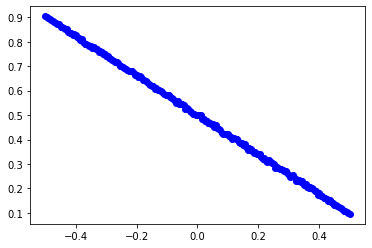

In [9]:
crooked = -0.4
sample_size = 10000

samples = crooked_coin_toss(crooked, sample_size)
x_s = np.arange(201)/200 - 0.5
y_s = []
for x in x_s:
    y_s.append(np.average( samples == crooked_coin_toss(x, sample_size)))

print(max(y_s))
plt.plot(x_s, y_s, 'bo')

## Uneven distribution of classes

In [10]:
def uneven_dist(p, num_classes = 10, num_samples=10000):
    rng = np.random.default_rng()
    return rng.choice(num_classes, num_samples, p)

In [11]:
p_s = np.random.randint(100, size = 10)
p_s = list(p_s / p_s.sum())

samples = uneven_dist(p_s, 10, 10000)
np.average( samples == uneven_dist(p_s, 10, 10000))

0.0995

# Subclassing

Let us revisit the toy example we discussed earlier, namely binary classification with manual feature selection.

In [12]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

def digit_indices(digit, labels = train_labels):
    return np.where(labels==digit)

def average_digit_image(digit, images = train_images, labels = train_labels):
    return np.average(images[digit_indices(labels, digit)],axis=0)

average_digits = np.array([average_digit_image(i) for i in range(10)]).reshape((10,28*28))
average_digits = average_digits.astype("float32") / 255
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype("float32") / 255

11501568/11490434 [==============================] - 0s 0us/step


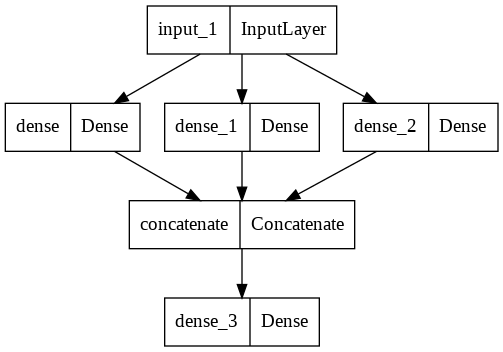

In [13]:
is9_input = layers.Input(shape=28*28)
is9_layer_ze = layers.Dense(1, trainable=False)(is9_input)
is9_layer_bt = layers.Dense(1, trainable=False)(is9_input)
is9_layer_at = layers.Dense(1, trainable=False)(is9_input)
is9_layer_cc = layers.Concatenate(axis=1)([is9_layer_ze, is9_layer_bt, is9_layer_at])
is9_output = layers.Dense(1, activation="sigmoid")(is9_layer_cc)

is9_model = keras.Model(inputs = is9_input,
                        outputs = is9_output,
                        name="is9")

is9_model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["binary_accuracy"])

keras.utils.plot_model(is9_model, "MNIST_with_binary_classifiers9.png")

In [14]:
mask9 = np.zeros((28*28, 3), dtype="float32")

for i in range(28*28):
    if average_digits[9, i] == 0:
        mask9[i, 0] += 1
    elif average_digits[9, i] <= 0.5:
        mask9[i, 1] += 1
    else:
        mask9[i, 2] += 1

for i in range(3):
    is9_model.layers[i+1].set_weights([mask9[:,i].reshape((-1,1)), 
                                       np.zeros(shape=(1,), dtype="float32")])

#is9_model.save_weights('is9_model_weights.h5')

In [15]:
train_labels_9 = np.logical_not((train_labels - 9).astype("bool")).astype("float32")
is9_model.fit(train_images, train_labels_9, 
                        validation_split=0.2, 
                        epochs=20, batch_size=128)

Epoch 1/20
375/375 [==============================] - 2s 3ms/step - loss: 81.8773 - binary_accuracy: 0.1000 - val_loss: 63.9858 - val_binary_accuracy: 0.0956
Epoch 2/20
375/375 [==============================] - 1s 3ms/step - loss: 46.6812 - binary_accuracy: 0.1000 - val_loss: 28.9205 - val_binary_accuracy: 0.0956
Epoch 3/20
375/375 [==============================] - 1s 2ms/step - loss: 12.1915 - binary_accuracy: 0.2325 - val_loss: 0.3129 - val_binary_accuracy: 0.9044
Epoch 4/20
375/375 [==============================] - 1s 2ms/step - loss: 0.2348 - binary_accuracy: 0.9112 - val_loss: 0.2137 - val_binary_accuracy: 0.9209
Epoch 5/20
375/375 [==============================] - 1s 2ms/step - loss: 0.2155 - binary_accuracy: 0.9191 - val_loss: 0.2084 - val_binary_accuracy: 0.9224
Epoch 6/20
375/375 [==============================] - 1s 2ms/step - loss: 0.2134 - binary_accuracy: 0.9193 - val_loss: 0.2069 - val_binary_accuracy: 0.9227
Epoch 7/20
375/375 [==============================] - 1s 2m

This model does a terrible job at identifying the digit 9. But remember that the model only has 4 trainable parameters! Perhaps introducing a few more would help improve the performance.

Before we move on I'd like to discuss whether there's a cleaner way to implement this model.

## Subclassing models

In [16]:
class masked_binary_classifier(keras.Model):
    def __init__(self, mask):
        super().__init__()
        self.ze_layer = layers.Dense(1, trainable=False)
        self.bt_layer = layers.Dense(1, trainable=False)
        self.at_layer = layers.Dense(1, trainable=False)
        self.concat_layer = layers.Concatenate(axis=1)
        self.output_layer = layers.Dense(1, activation="sigmoid")
        self.mask = mask
        self.ze_layer.build(input_shape = (None, 784))
        self.bt_layer.build(input_shape = (None, 784))
        self.at_layer.build(input_shape = (None, 784))
        self.ze_layer.set_weights([self.mask[:,0].reshape((-1,1)),
                                   np.zeros(shape=(1,), dtype="float32")])
        self.bt_layer.set_weights([self.mask[:,1].reshape((-1,1)),
                                   np.zeros(shape=(1,), dtype="float32")])
        self.at_layer.set_weights([self.mask[:,2].reshape((-1,1)),
                                   np.zeros(shape=(1,), dtype="float32")])

    def call(self, inputs):
        output = [self.ze_layer(inputs), 
                  self.bt_layer(inputs),
                  self.at_layer(inputs)]
        output = self.concat_layer(output)
        output = self.output_layer(output)
        return output

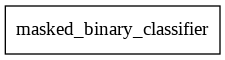

In [17]:
is9_sc_model = masked_binary_classifier(mask9)
is9_sc_model.build(input_shape = (None,784))
#is9_sc_model.load_weights('is9_model_weights.h5')
is9_sc_model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["binary_accuracy"])

keras.utils.plot_model(is9_sc_model, "MNIST_with_binary_classifiers_sc9.png")

In [18]:
is9_sc_model.summary()

Model: "masked_binary_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             multiple                  785       
                                                                 
 dense_5 (Dense)             multiple                  785       
                                                                 
 dense_6 (Dense)             multiple                  785       
                                                                 
 concatenate_1 (Concatenate)  multiple                 0         
                                                                 
 dense_7 (Dense)             multiple                  4         
                                                                 
Total params: 2,359
Trainable params: 4
Non-trainable params: 2,355
_________________________________________________________________


In [19]:
(is9_sc_model.layers[1].get_weights()[0] == mask9[:,1].reshape(-1,1)).all()

True

In [20]:
train_labels_9 = np.logical_not((train_labels - 9).astype("bool")).astype("float32")
is9_sc_model.fit(train_images, train_labels_9, 
                        validation_split=0.2, 
                        epochs=20, batch_size=128)

Epoch 1/20
375/375 [==============================] - 2s 3ms/step - loss: 0.3193 - binary_accuracy: 0.8835 - val_loss: 0.2300 - val_binary_accuracy: 0.9121
Epoch 2/20
375/375 [==============================] - 1s 2ms/step - loss: 0.2313 - binary_accuracy: 0.9115 - val_loss: 0.2230 - val_binary_accuracy: 0.9164
Epoch 3/20
375/375 [==============================] - 1s 2ms/step - loss: 0.2263 - binary_accuracy: 0.9138 - val_loss: 0.2178 - val_binary_accuracy: 0.9183
Epoch 4/20
375/375 [==============================] - 1s 2ms/step - loss: 0.2228 - binary_accuracy: 0.9150 - val_loss: 0.2166 - val_binary_accuracy: 0.9185
Epoch 5/20
375/375 [==============================] - 1s 2ms/step - loss: 0.2201 - binary_accuracy: 0.9164 - val_loss: 0.2121 - val_binary_accuracy: 0.9210
Epoch 6/20
375/375 [==============================] - 1s 2ms/step - loss: 0.2174 - binary_accuracy: 0.9170 - val_loss: 0.2101 - val_binary_accuracy: 0.9220
Epoch 7/20
375/375 [==============================] - 1s 2ms/ste

## Subclassing layers

In [21]:
class digit_masking(keras.layers.Layer):
    def __init__(self, digit_mask):
        super().__init__()
        self.units = 1
        self.activation = tf.nn.sigmoid
        self.digit_mask = digit_mask

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.W = self.add_weight(shape = (3,1),
                                 initializer="random_normal")
        self.b = self.add_weight(shape = (1,), 
                                 initializer="zeros")
        
    def call(self, inputs):
        y = tf.matmul(inputs, self.digit_mask)
        y = tf.matmul(y, self.W) + self.b
        y = self.activation(y)
        return y

In [22]:
mask9 = np.zeros((28*28, 3), dtype="float32")

for i in range(28*28):
    if average_digits[9, i] == 0:
        mask9[i, 0] += 1
    elif average_digits[9, i] <= 0.5:
        mask9[i, 1] += 1
    else:
        mask9[i, 2] += 1

mask9.shape

(784, 3)

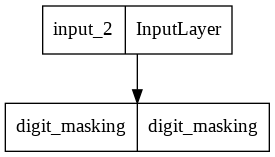

In [23]:
is9_input = layers.Input(shape=28*28)
mask_layer = digit_masking(mask9)(is9_input)

is9_model = keras.Model(inputs = is9_input,
                        outputs = mask_layer,
                        name="is9")

is9_model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["binary_accuracy"])

keras.utils.plot_model(is9_model, "MNIST_with_binary_classifiers9.png")

In [24]:
is9_model.summary()

Model: "is9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 784)]             0         
                                                                 
 digit_masking (digit_maskin  (None, 1)                4         
 g)                                                              
                                                                 
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [25]:
train_labels_9 = np.logical_not((train_labels - 9).astype("bool")).astype("float32")
is9_model.fit(train_images, train_labels_9, 
                        validation_split=0.2, 
                        epochs=20, batch_size=128)

Epoch 1/20
375/375 [==============================] - 1s 3ms/step - loss: 0.4371 - binary_accuracy: 0.8315 - val_loss: 0.2300 - val_binary_accuracy: 0.9158
Epoch 2/20
375/375 [==============================] - 1s 2ms/step - loss: 0.2338 - binary_accuracy: 0.9121 - val_loss: 0.2240 - val_binary_accuracy: 0.9170
Epoch 3/20
375/375 [==============================] - 1s 2ms/step - loss: 0.2286 - binary_accuracy: 0.9132 - val_loss: 0.2196 - val_binary_accuracy: 0.9190
Epoch 4/20
375/375 [==============================] - 1s 3ms/step - loss: 0.2246 - binary_accuracy: 0.9154 - val_loss: 0.2201 - val_binary_accuracy: 0.9178
Epoch 5/20
375/375 [==============================] - 1s 2ms/step - loss: 0.2211 - binary_accuracy: 0.9168 - val_loss: 0.2133 - val_binary_accuracy: 0.9207
Epoch 6/20
375/375 [==============================] - 1s 2ms/step - loss: 0.2184 - binary_accuracy: 0.9173 - val_loss: 0.2113 - val_binary_accuracy: 0.9214
Epoch 7/20
375/375 [==============================] - 1s 2ms/ste

#Exercise

Construct a classifying model such that a feedforward would randomly seperate the input data into 2 disjoint sets, pass them through 2 separate hidden nodes before combining their outputs and feeding it to the model's output layer. (Hint: You can utilize dropout and subtract layers.)

##Solution

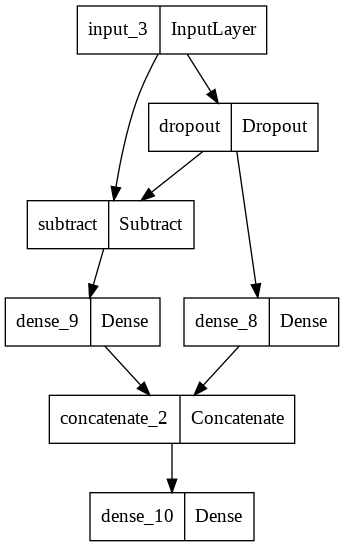

In [26]:
split_model_input = layers.Input(shape=28*28)
split_model_b1 = layers.Dropout(0.5)(split_model_input)
split_model_b2 = layers.Subtract()([split_model_input, split_model_b1])
split_model_relu1 = layers.Dense(256, activation='relu')(split_model_b1)
split_model_relu2 = layers.Dense(256, activation='relu')(split_model_b2)
split_model_concat = layers.Concatenate(axis=1)([split_model_relu1,
                                                 split_model_relu2])
split_model_output = layers.Dense(10, activation='softmax')(split_model_concat)


split_model = keras.Model(inputs = split_model_input,
                          outputs = split_model_output,
                          name = "split_model")

split_model.compile(optimizer="rmsprop",
                    loss="sparse_categorical_crossentropy",
                    metrics=["accuracy"])

keras.utils.plot_model(split_model, "MNIST_split.png")

In [27]:
split_model.fit(train_images, train_labels, 
                validation_split= 0.2, 
                epochs=40, 
                batch_size=128)

Epoch 1/40
375/375 [==============================] - 6s 14ms/step - loss: 0.4805 - accuracy: 0.8583 - val_loss: 0.2214 - val_accuracy: 0.9379
Epoch 2/40
375/375 [==============================] - 5s 13ms/step - loss: 0.2464 - accuracy: 0.9270 - val_loss: 0.1587 - val_accuracy: 0.9542
Epoch 3/40
375/375 [==============================] - 5s 13ms/step - loss: 0.1863 - accuracy: 0.9431 - val_loss: 0.1290 - val_accuracy: 0.9611
Epoch 4/40
375/375 [==============================] - 5s 13ms/step - loss: 0.1553 - accuracy: 0.9531 - val_loss: 0.1139 - val_accuracy: 0.9666
Epoch 5/40
375/375 [==============================] - 5s 13ms/step - loss: 0.1403 - accuracy: 0.9567 - val_loss: 0.1078 - val_accuracy: 0.9678
Epoch 6/40
375/375 [==============================] - 5s 13ms/step - loss: 0.1264 - accuracy: 0.9619 - val_loss: 0.1026 - val_accuracy: 0.9701
Epoch 7/40
375/375 [==============================] - 5s 13ms/step - loss: 0.1212 - accuracy: 0.9622 - val_loss: 0.0952 - val_accuracy: 0.9706

# Overfitting

Lets do something you should never do and must always be wary of:

we are going to mark our data and track the effect during training.

In [8]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

def digit_indices(digit, labels = train_labels):
    return np.where(labels==digit)

def average_digit_image(digit, images = train_images, labels = train_labels):
    return np.average(images[digit_indices(labels, digit)],axis=0)

average_digits = np.array([average_digit_image(i) for i in range(10)]).reshape((10,28*28))
average_digits = average_digits.astype("float32") / 255
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype("float32") / 255

In [28]:
for i in digit_indices(0):
    train_images[i, 783] += 1

In [29]:
is0_input = layers.Input(shape=28*28)
is0_output = layers.Dense(1, activation='sigmoid')(is0_input)

is0_model = keras.Model(inputs = is0_input,
                        outputs = is0_output,
                        name="is0")

is0_model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["binary_accuracy"])

weight_783 = []
pixel_callback = keras.callbacks.LambdaCallback(
    on_epoch_end = lambda batch, logs: weight_783.append(is0_model.layers[1].get_weights()[0][783,0]))

In [30]:
num_epochs = 40
weight_783 = []
train_labels_0 = np.logical_not((train_labels - 0).astype("bool")).astype("float32")
history = is0_model.fit(train_images, train_labels_0, 
                        validation_split=0.2, 
                        epochs=num_epochs, 
                        batch_size=128,
                        callbacks=[pixel_callback],
                        verbose=0)

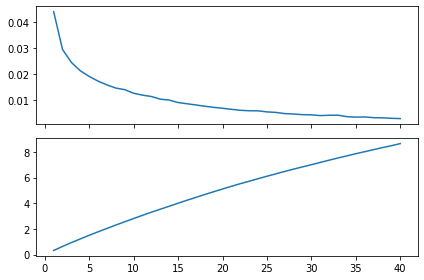

In [31]:
history_dict = history.history
loss_values = history_dict["loss"]

fig, axs = plt.subplots(2, sharex=True, tight_layout=True)

start = 1
val_loss_values = history_dict["val_loss"]
epochs = range(start, len(loss_values) + 1)

axs[0].plot(epochs, val_loss_values)
axs[1].plot(epochs, weight_783)

### Weight regularization

In [32]:
from tensorflow.keras import regularizers
is0_input = layers.Input(shape=28*28)
is0_output = layers.Dense(1, 
                          kernel_regularizer = regularizers.l1_l2(l1 = 1e-4, l2 = 1e-3),
                          activation='sigmoid')(is0_input)

is0_model = keras.Model(inputs = is0_input,
                        outputs = is0_output,
                        name="is0")

is0_model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["binary_accuracy"])

weight_783 = []
pixel_callback = keras.callbacks.LambdaCallback(
    on_epoch_end = lambda batch, logs: weight_783.append(is0_model.layers[1].get_weights()[0][783,0]))

In [33]:
num_epochs = 40
weight_783 = []
train_labels_0 = np.logical_not((train_labels - 0).astype("bool")).astype("float32")
history = is0_model.fit(train_images, train_labels_0, 
                        validation_split=0.2, 
                        epochs=num_epochs, 
                        batch_size=128,
                        callbacks=[pixel_callback],
                        verbose=0)

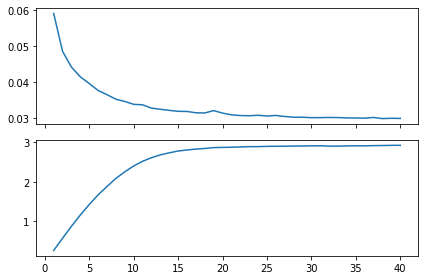

In [34]:
history_dict = history.history
loss_values = history_dict["loss"]

fig, axs = plt.subplots(2, sharex=True, tight_layout=True)

start = 1
val_loss_values = history_dict["val_loss"]
epochs = range(start, len(loss_values) + 1)

axs[0].plot(epochs, val_loss_values)
axs[1].plot(epochs, weight_783)

What would the effect of a dropout layer be?

In [35]:
average_digits

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [36]:
identifying_features = []
for i in range(784):
    if (average_digits[:,i] > 0.6).sum() == 1:
        identifying_features.append(i)

In [37]:
for feature in identifying_features:
    x = (train_images[:,feature] > 0.8).sum()
    if x < 7000:
        print(feature, x)

357 6516
385 6363
413 6768


In [38]:
labels_385 = []
for i in range(60000):
    if train_images[i, 385] > 0.8:
        labels_385.append(i)
(train_labels[labels_385] == 0).sum()

3031

The above analysis implies that a single pixel can tell us if an image is a 0 or not with ~95% accuracy!

#Mimicing a decision tree with Neural Networks

In [39]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

def digit_indices(digit, labels = train_labels):
    return np.where(labels==digit)

def average_digit_image(digit, images = train_images, labels = train_labels):
    return np.average(images[digit_indices(labels, digit)],axis=0)

average_digits = np.array([average_digit_image(i) for i in range(10)]).reshape((10,28*28))
average_digits = average_digits.astype("float32") / 255
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype("float32") / 255

In [41]:
def digit_overlaps(image1, image2):
    return np.abs(image1 - image2).sum()/(image1 + image2).sum()

In [42]:
overlaps = [ [digit_overlaps(average_digits[i], average_digits[j]) for i in range(10)] for j in range(10)]

In [43]:
max_overlaps = []
for i in range(10):
    x = sorted(overlaps[i], reverse=True)
    max_overlaps.append([overlaps[i].index(y) for y in x])

In [44]:
max_overlaps

[[1, 7, 9, 4, 6, 2, 3, 8, 5, 0],
 [0, 4, 6, 7, 9, 2, 3, 5, 8, 1],
 [1, 7, 9, 0, 4, 5, 6, 3, 8, 2],
 [1, 7, 4, 6, 9, 0, 2, 8, 5, 3],
 [1, 0, 3, 2, 6, 5, 7, 8, 9, 4],
 [1, 7, 2, 6, 4, 9, 0, 3, 8, 5],
 [1, 7, 3, 0, 9, 4, 8, 5, 2, 6],
 [1, 6, 0, 2, 3, 5, 8, 4, 9, 7],
 [1, 7, 6, 0, 4, 9, 2, 3, 5, 8],
 [1, 0, 3, 2, 6, 5, 8, 7, 4, 9]]

Lets pair the last leaves as follows:

(0,1) , (2,7) , (3,4) , (5,6) , (8,9)

In [45]:
def decision_labels(labels, d0, d1, other=[]):
    if other:
        x = 3
    else:
        x = 2
    num_samples = labels.shape[0]
    new_labels = np.zeros(shape=(num_samples, x))
    for i in range(num_samples):
        if labels[i] in d0:
            new_labels[i, 0] += 1
        elif labels[i] in d1:
            new_labels[i, 1] += 1
        else:
            new_labels[i, 2] += 1
    return new_labels

model_input = layers.Input(shape=28*28)

In [46]:
class tree_branch(keras.Model):
    def __init__(self, mask):
        super().__init__()
        self.cc = layers.Concatenate(axis=1)
        self.hl = layers.Dense(512, activation='relu')
        self.out = layers.Dense(3, activation='softmax')

    def call(self, inputs):
        output = self.cc(inputs)
        output = self.hl(output)
        output = self.out(output)
        return output

In [47]:
# Decision0 0-9 --> 012789, 3456
train_labels_d0 = decision_labels(train_labels, [0,1,2,7,8,9], [3,4,5,6])
hl_d0 = layers.Dense(512, activation='relu')(model_input)
out_d0 = layers.Dense(2, activation='softmax')(hl_d0)

model_d0 = keras.Model(inputs = model_input,
                       outputs = out_d0,
                       name="D0")

model_d0.compile(optimizer="adam",
                 loss="binary_crossentropy",
                 metrics=["binary_accuracy"])

model_d0.fit(train_images, train_labels_d0,
             validation_split=0.2,
             epochs=10,
             batch_size=128)

Epoch 1/10
375/375 [==============================] - 4s 10ms/step - loss: 0.1580 - binary_accuracy: 0.9414 - val_loss: 0.0813 - val_binary_accuracy: 0.9718
Epoch 2/10
375/375 [==============================] - 3s 9ms/step - loss: 0.0705 - binary_accuracy: 0.9757 - val_loss: 0.0689 - val_binary_accuracy: 0.9772
Epoch 3/10
375/375 [==============================] - 3s 9ms/step - loss: 0.0474 - binary_accuracy: 0.9843 - val_loss: 0.0639 - val_binary_accuracy: 0.9782
Epoch 4/10
375/375 [==============================] - 3s 9ms/step - loss: 0.0341 - binary_accuracy: 0.9887 - val_loss: 0.0578 - val_binary_accuracy: 0.9808
Epoch 5/10
375/375 [==============================] - 3s 9ms/step - loss: 0.0241 - binary_accuracy: 0.9924 - val_loss: 0.0453 - val_binary_accuracy: 0.9840
Epoch 6/10
375/375 [==============================] - 3s 9ms/step - loss: 0.0173 - binary_accuracy: 0.9951 - val_loss: 0.0480 - val_binary_accuracy: 0.9838
Epoch 7/10
375/375 [==============================] - 3s 9ms/st

In [48]:
# Decision00 012789 --> 0127, 89
train_labels_d00 = decision_labels(train_labels, [0,1,2,7], [8,9], [3,4,5,6])
d0 = keras.Input(shape=(2,))
model_d00 = tree_branch([model_input, d0])

model_d00.compile(optimizer="adam",
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

In [49]:
model_d00.fit([train_images, train_labels_d0], train_labels_d00,
              epochs=10,
              batch_size=128)

Epoch 1/10
469/469 [==============================] - 4s 8ms/step - loss: 0.0968 - accuracy: 0.9684
Epoch 2/10
469/469 [==============================] - 4s 8ms/step - loss: 0.0245 - accuracy: 0.9918
Epoch 3/10
469/469 [==============================] - 4s 8ms/step - loss: 0.0155 - accuracy: 0.9951
Epoch 4/10
469/469 [==============================] - 4s 8ms/step - loss: 0.0112 - accuracy: 0.9964
Epoch 5/10
469/469 [==============================] - 4s 8ms/step - loss: 0.0085 - accuracy: 0.9973
Epoch 6/10
469/469 [==============================] - 4s 8ms/step - loss: 0.0064 - accuracy: 0.9981
Epoch 7/10
469/469 [==============================] - 4s 8ms/step - loss: 0.0050 - accuracy: 0.9982
Epoch 8/10
469/469 [==============================] - 4s 8ms/step - loss: 0.0040 - accuracy: 0.9987
Epoch 9/10
469/469 [==============================] - 4s 8ms/step - loss: 0.0024 - accuracy: 0.9994
Epoch 10/10
469/469 [==============================] - 4s 8ms/step - loss: 0.0018 - accuracy: 0.9995

### Putting d0 and d00 together

In [50]:
model_d0.summary()

Model: "D0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_13 (Dense)            (None, 512)               401920    
                                                                 
 dense_14 (Dense)            (None, 2)                 1026      
                                                                 
Total params: 402,946
Trainable params: 402,946
Non-trainable params: 0
_________________________________________________________________


In [51]:
model_d00.summary()

Model: "tree_branch"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 concatenate_3 (Concatenate)  multiple                 0         
                                                                 
 dense_15 (Dense)            multiple                  402944    
                                                                 
 dense_16 (Dense)            multiple                  1539      
                                                                 
Total params: 404,483
Trainable params: 404,483
Non-trainable params: 0
_________________________________________________________________


In [52]:
d0_weights = [model_d0.layers[1].get_weights(), model_d0.layers[2].get_weights()]
d00_weights = [model_d00.layers[1].get_weights(), model_d00.layers[2].get_weights()]

In [53]:
hl1_d0d00 = layers.Dense(512, activation='relu', trainable=False)(model_input)
d0_d0d00 = layers.Dense(2, activation='softmax', trainable=False)(hl1_d0d00)
cc_d0d00 = layers.Concatenate(axis=1)([model_input, d0_d0d00])
hl2_d0d00 = layers.Dense(512, activation='relu', trainable=False)(cc_d0d00)
out_d0d00 = layers.Dense(3, activation='softmax', trainable=False)(hl2_d0d00)
model_d0d00 = keras.Model(inputs = model_input, outputs = out_d0d00)

model_d0d00.build(input_shape=(784,))

model_d0d00.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 dense_17 (Dense)               (None, 512)          401920      ['input_6[0][0]']                
                                                                                                  
 dense_18 (Dense)               (None, 2)            1026        ['dense_17[0][0]']               
                                                                                                  
 concatenate_4 (Concatenate)    (None, 786)          0           ['input_6[0][0]',                
                                                                  'dense_18[0][0]']           

In [54]:
model_d0d00.layers[1].set_weights(d0_weights[0])
model_d0d00.layers[2].set_weights(d0_weights[1])
model_d0d00.layers[4].set_weights(d00_weights[0])
model_d0d00.layers[5].set_weights(d00_weights[1])

In [56]:
model_d0d00.compile(optimizer="adam",
                    loss="categorical_crossentropy",
                    metrics=["accuracy"])

test_labels_d00 = decision_labels(test_labels, [0,1,2,7], [8,9], [3,4,5,6])
model_d0d00.evaluate(test_images, test_labels_d00)

313/313 [==============================] - 3s 7ms/step - loss: 0.1362 - accuracy: 0.9830


[0.1362091600894928, 0.9829999804496765]